In [11]:
import torch
import torch.nn as nn
from helpers.smpl_to_df import smpl_to_df
from helpers.leg_fix import fix_legs
import matplotlib.pyplot as plt
import numpy as np


In [12]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # Batch Normalization after the first linear layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)  # Dropout
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.relu(x)
        x = self.dropout(x)  # Apply Dropout
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


In [13]:
#load the model with the correct dimensions
model = NN(69, 64, 2)
model.load_state_dict(torch.load("model.pt"))
model.eval()

#load test data
file = "data/demo_walk_1.pkl"

#apply leg fix to test data

test, x_coords = smpl_to_df(file)
test = fix_legs(test)
torch_test = torch.tensor(test.values).float()

(67, 69)


In [14]:
#predict
pred = model(torch_test)

**Left & Right Contact Estimation**

The following plot shows the probability of right and left leg contact with the ground, as inferred by the model

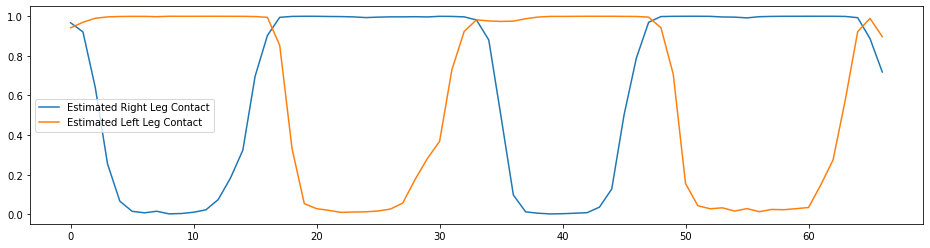

In [15]:
#plot the results
plt.plot(pred.detach().numpy()[:,0], label="Estimated Right Leg Contact")
plt.plot(pred.detach().numpy()[:,1], label="Estimated Left Leg Contact")

#make the figure bigger
fig = plt.gcf()
fig.set_size_inches(16, 4)

plt.legend()

plt.show()


**Double Support**

The following plot shows the double support inferred by the model

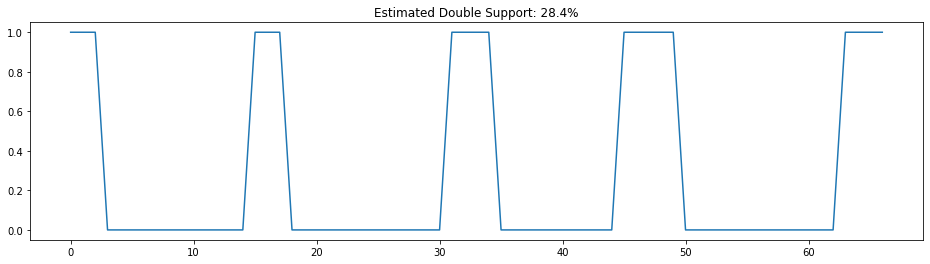

In [16]:
pred_round = torch.round(pred)
ds = []
#find the indices where both legs are in contact
for i in range(len(pred_round)):
    if pred_round[i][0] == 1 and pred_round[i][1] == 1:
        ds.append(1)
    else:
        ds.append(0)
est_ds = sum(ds)/len(ds)

plt.plot(ds)
fig = plt.gcf()
fig.set_size_inches(16, 4)
plt.title(f"Estimated Double Support: {str(np.round(est_ds*100, 1))}%")
plt.show()


**Stride Length and Asymmetry Estimation**

Stride length is estimated from the distance travelled in X for each walking phase

In [17]:
def get_touches(touch_list):
    touches = []
    for i in range(len(touch_list)):
        if touch_list[i] == 1 and touch_list[i-1] == 0:
            touches.append(i)
    return touches

right_touch = get_touches(pred_round.detach().numpy()[:,0])
left_touch = get_touches(pred_round.detach().numpy()[:,1])


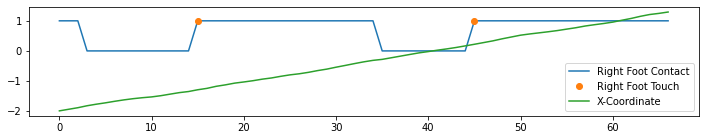

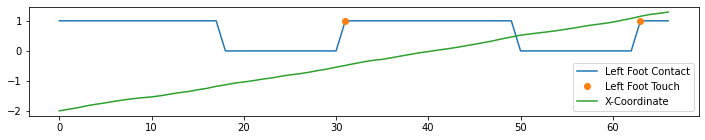

In [18]:
#plot right and left foot contacts
plt.plot(pred_round.detach().numpy()[:,0], label="Right Foot Contact")
plt.plot(right_touch, [1]*len(right_touch), "o", label="Right Foot Touch")
plt.plot(x_coords, label="X-Coordinate")


plt.legend()
fig = plt.gcf()
fig.set_size_inches(12, 2)
plt.show()

plt.plot(pred_round.detach().numpy()[:,1], label="Left Foot Contact")
plt.plot(left_touch, [1]*len(left_touch), "o", label="Left Foot Touch")
plt.plot(x_coords, label="X-Coordinate")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12, 2)
plt.show()


In [19]:
stride_length_right = x_coords[right_touch[1:], 0] - x_coords[right_touch[:-1], 0]
stride_length_left = x_coords[left_touch[1:], 0] - x_coords[left_touch[:-1], 0]

#avg stride length in centimeters multiplied by learned scale factor from difference between SMPL X distance and measured distance
scale_f = 1.226993865
avg_stride_length_left = np.mean(stride_length_left)*100*scale_f
avg_stride_length_right = np.mean(stride_length_right)*100*scale_f

In [20]:
print(f"average right stride length: {np.round(avg_stride_length_right, 2)}cm")
print(f"average left stride length: {np.round(avg_stride_length_left, 2)}cm")
#calculate the assymetry
asy = np.abs(avg_stride_length_left - avg_stride_length_right)/(avg_stride_length_left + avg_stride_length_right)
print(f"assymetry: {np.round(asy*100, 2)}%")

average right stride length: 185.48cm
average left stride length: 200.24cm
assymetry: 3.82%
